# Generation of "Similar" Sentences Using The Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [1]:
# To Try:
# * Deeper Network with the dense layers
#   * Batch norm, higher lr 
#     https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
#     If this causes dying ReLU, look into LeakyReLU, etc. 
# * Optimizing just the LSTM in the encoder and possibly decoder
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer, BatchNormalization
from keras.layers import Activation, Dropout, Activation
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import objectives

from keras.models import Model

from keras import backend as K
from keras.utils import plot_model

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data

### Overview

Originally we were using a dataset of quora questions.
However, it became immediately clear that the model was
learning a single sentence which could minimize the loss
function. So, we are trying another dataset which
consists of Wikipedia sentences. It is worth noting that
this dataset has not been vetted. It is also known that
wikipedia articles contain some level of noise.

The dataset consists of roughly 800,000 questions
posted on Quora. This data was made publicly
available via Kaggle at this 
[link](https://www.kaggle.com/quora/question-pairs-dataset).
The original intent of this dataset was to find 
duplicate questions, but it works well for our 
purposes.

### Download

There are multiple ways to download the data. My
preference is to use the kaggle API.

Start by searching for the dataset

```
kaggle datasets list -s quora
```

Once you find the dataset, download it with

```
kaggle datasets download quora/question-pairs-dataset
```

This downloads a zip file. I'm working on 
Ubuntu, so I can unzip with

```
unzip question-pairs-dataset.zip
```

### Preprocess

There is a fair bit of work to be done to preprocess the data. 

### Merge Questions

Because the dataset was originally published
to find duplicates, it has two columns with 
questions. We need to take these columns and
stack them horizontally. 

Worth noting, it's possible there's some
risk of overlapping questions, because some
are semantically duplicative.

In [2]:
project_path = r'/home/das-hund/PycharmProjects/autoencoders'
data_path = os.path.join(project_path, 'data')
question_path = os.path.join(data_path, 'questions.csv')
merged_questions_path = os.path.join(data_path, 'merged.csv')
questions = pd.read_csv(question_path)

questions_one = questions.question1
questions_two = questions.question2

merged = pd.concat([
    questions_one, questions_two
])
merged = merged.sample(frac=1).reset_index(drop=True)
merged.to_csv(
    merged_questions_path,
    index=False, header=False
)

print(f'[+] {len(merged)} questions in {merged_questions_path}.')

print(f'[+] First 5 records of merged questions:')
print(merged.head(5))

del questions, questions_one
del questions_two, merged

[+] 808702 questions in /home/das-hund/PycharmProjects/autoencoders/data/merged.csv.
[+] First 5 records of merged questions:
0    As a man, how do I deal with a bossy woman who...
1    How much money did Nike spend on advertisement...
2    Why do people think space exploration is a was...
3                 What causes pimples on the buttocks?
4    How do I hack WhatsApp account of someone else...
dtype: object


### Tokenize

We will split the texts by new lines. 
This gives us a record for each question. Then
we fit a tokenizer on our texts, mapping words
to integers.

We aren't limiting the number of words, yet. 
We will see how the model performs, in the 
near future. In addition, I'm not going to
limit sequence lengths, yet. I want to see
how long the sequences are.

#### Train the Tokenizer

In [3]:
# Tokenizer doesn't seem to be working properly. 
MAX_WORDS = 20000
MAX_SEQ_LEN = 12 #25 Worried the model is just going to predict 0


with open(merged_questions_path, 'r') as question_file:
    texts = question_file.read().split('\n')
DATA_LEN = 128000#512000
texts = texts[:DATA_LEN]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
tokenizer.num_words = MAX_WORDS
word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [4]:
sequences = tokenizer.texts_to_sequences(texts)

#### Summary Stats 

[[4, 73, 67, 54, 5790, 847, 20, 5526, 8, 1306], [16, 9, 38, 79, 429, 8427, 3, 6, 2355, 10, 67], [2, 510, 2094, 20, 1, 16990], [4, 9, 5, 448, 327, 136, 10, 85, 950, 33, 143, 716], [2, 11, 26, 6928, 1961, 8, 1645], [2, 3, 1, 935, 10, 7867, 213, 8, 449, 904], [389, 14, 2571, 7, 1828, 1646, 12, 204, 5791, 12, 9125, 1465, 27, 28, 184, 12, 387, 3349, 58, 1736], [2, 3, 1, 252, 1647, 10, 227], [363, 4, 13, 5, 30, 204, 6, 14055, 363, 136]]
[+] Max Sequence Length: 237
[+] Word Count: 41863


(array([1.22562e+05, 5.28200e+03, 1.50000e+02, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00]),
 array([  0. ,  23.7,  47.4,  71.1,  94.8, 118.5, 142.2, 165.9, 189.6,
        213.3, 237. ]),
 <a list of 10 Patch objects>)

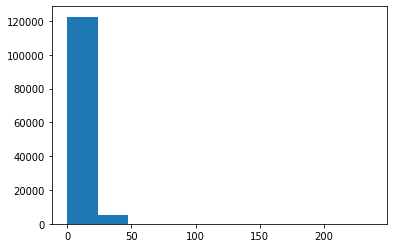

In [5]:
print(sequences[1:10])
sequence_lengths = np.array([
    len(seq) for seq in sequences
])

max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

sequence_lengths = np.array([
    len(seq) for seq in sequences
])
%matplotlib inline
plt.hist(sequence_lengths)

In [6]:
print(f'[+] {len(word_to_index)} words found in {merged_questions_path}')

print('[+] Word Map Subset:\n{')
for _, (word, index) in zip(range(40), word_to_index.items()):
    print('\t{}: {}'.format(word, index))
print('\t...\n}')

[+] 41863 words found in /home/das-hund/PycharmProjects/autoencoders/data/merged.csv
[+] Word Map Subset:
{
	the: 1
	what: 2
	is: 3
	how: 4
	i: 5
	a: 6
	to: 7
	in: 8
	do: 9
	of: 10
	are: 11
	and: 12
	can: 13
	for: 14
	you: 15
	why: 16
	my: 17
	best: 18
	it: 19
	on: 20
	does: 21
	or: 22
	if: 23
	which: 24
	be: 25
	some: 26
	that: 27
	have: 28
	with: 29
	get: 30
	should: 31
	an: 32
	from: 33
	your: 34
	india: 35
	will: 36
	when: 37
	people: 38
	like: 39
	who: 40
	...
}


#### Sequence Generation

#### Pad Sequences

In [7]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [8]:
print(padded_sequences[0:5])
print(padded_sequences.shape)

[[    3  1960    17  1548  4646    22  4022     7   502    92    10  4247]
 [    0     0     4    73    67    54  5790   847    20  5526     8  1306]
 [    0    16     9    38    79   429  8427     3     6  2355    10    67]
 [    0     0     0     0     0     0     2   510  2094    20     1 16990]
 [    4     9     5   448   327   136    10    85   950    33   143   716]]
(128000, 12)


## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [9]:
from keras.layers.advanced_activations import ELU


def build_encoder(embedding, max_seq_len, 
                  latent_dim, intermediate_dim,
                  epsilon_std):
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=True, name='lstm_encoding_one'
    ), merge_mode='concat', name='bidirectional_encoding_one')(embedding)
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=False, name='lstm_encoding_two'
    ), merge_mode='concat', name='bidirectional_encoding_two')(h)
    h = Dense(
        intermediate_dim, use_bias=False, name='dense_encoding_one'
    )(h)
    h = BatchNormalization(name='bn_one')(h)
    h = Activation('relu', name='dense_encoding_one_activation')(h)
    h = Dense(
        intermediate_dim, activation='relu', name='dense_encoding_two'
    )(h)
    h = Dense(
        intermediate_dim // 2, activation='relu', name='dense_encoding_three'
    )(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon
    
    z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)
    z_log_var = Dense(latent_dim, activation='linear', name='z_log_var')(h)
    
    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_seq_len * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    latent = Lambda(
        sampling, output_shape=(latent_dim,), name='latent'
    )([z_mean, z_log_var])
    
    return vae_loss, latent


def build_decoder(encoded_input, intermediate_dim,
                  token_count, max_seq_len):
    repeated_context = RepeatVector(
        max_seq_len, name='repeated_context'
    )(encoded_input)
    
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_one'
    )(repeated_context)
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_two'
    )(h)
    
    decoded = TimeDistributed(Dense(
        token_count, activation='softmax', name='time_distributed_decoding'
    ), name='decoded_mean')(h)
    
    return decoded
    
    
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len,), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim,
        input_length=max_seq_len, name='embedding'
    )(encoder_input)
    
    vae_loss, encoded = build_encoder(
        embedding=embedding, max_seq_len=max_seq_len,
        latent_dim=latent_dim, intermediate_dim=intermediate_dim,
        epsilon_std=epsilon_std
    )
    
    encoder = Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    encoded_input = Input(shape=(latent_dim,), name='encoded_input')
    decoded = build_decoder(
        encoded_input=encoded_input, intermediate_dim=intermediate_dim,
        token_count=token_count, max_seq_len=max_seq_len
    )
    
    decoder = Model(encoded_input, decoded, name='decoder')
    
    # VAE
    vae = Model(
        encoder_input, 
        build_decoder(
            encoded_input=encoded, intermediate_dim=intermediate_dim,
            token_count=token_count, max_seq_len=max_seq_len
        ), 
        name='vae')
    vae.compile(
        optimizer='rmsprop',
        loss=vae_loss,
        metrics=['accuracy']
    )
    
    return vae, encoder, decoder


In [10]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
EMBED_DIM = 353
WORD_COUNT = MAX_WORDS
BATCH_SIZE = 128
STEPS_PER_EPOCH=DATA_LEN // BATCH_SIZE
INTERMEDIATE_DIM = 128
LATENT_DIM = 32

vae, encoder, decoder = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    epsilon_std=0.1
)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def complex_oh_encode(X_train, maxlen, num_words):
    temp = np.zeros((X_train.shape[0], maxlen, num_words))
    temp[
        np.expand_dims(
            np.arange(X_train.shape[0]), axis=0
        ).reshape(
            X_train.shape[0], 1
        ), np.repeat(
            np.array([np.arange(maxlen)]), X_train.shape[0], axis=0
        ), X_train
    ] = 1
    return temp

In [12]:
# Will need this when we get the model working.
def batch_generator(X, batch_size, max_seq_len, num_words):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], complex_oh_encode(X[batch], maxlen=max_seq_len, num_words=num_words)
                batch=[]

train_generator = batch_generator(
    X=padded_sequences, batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    num_words=WORD_COUNT
)

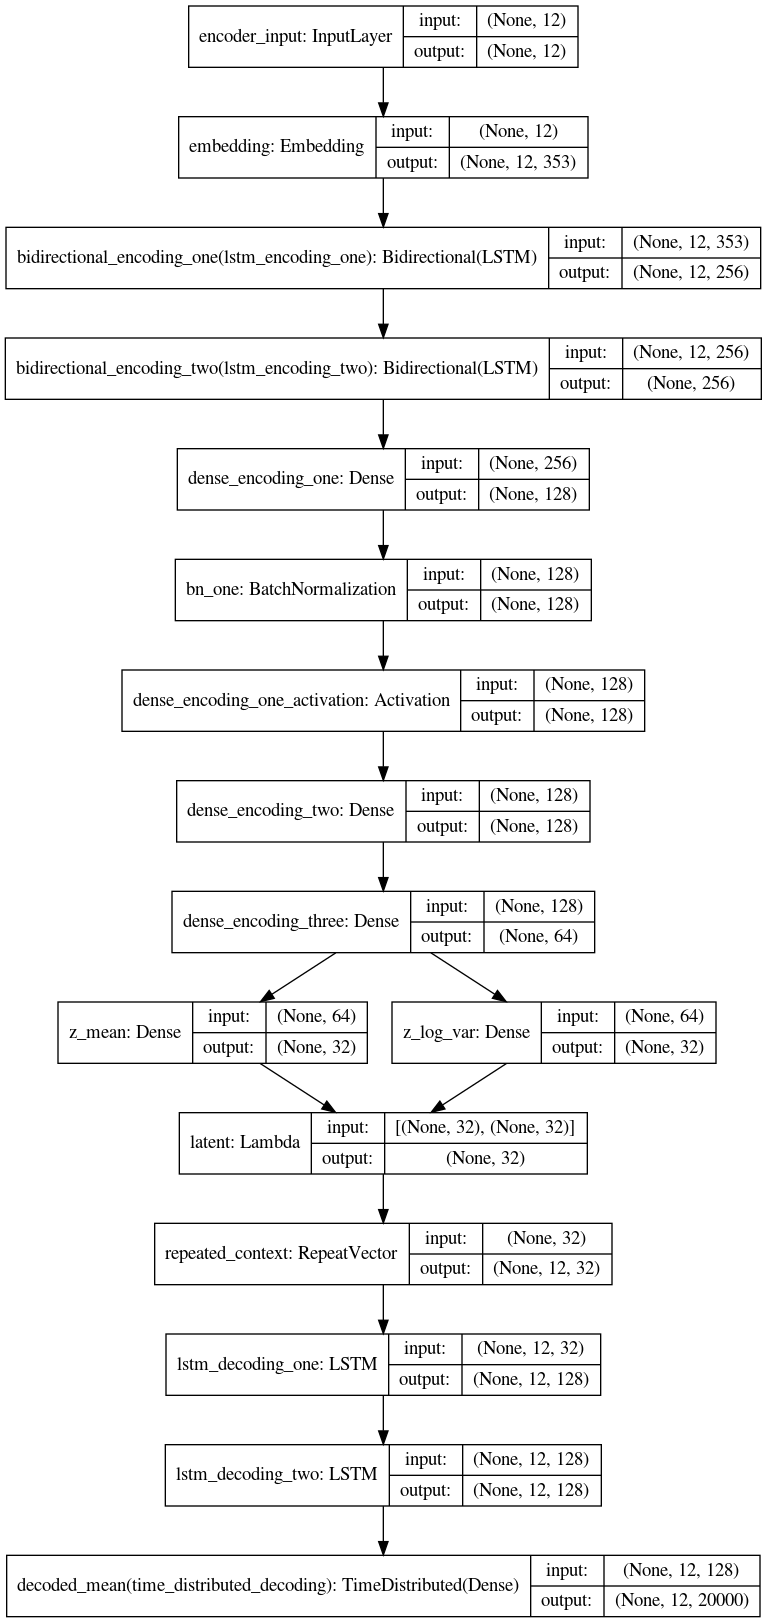

In [13]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [14]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 353)      7060000     encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoding_one (Bid (None, 12, 256)      493568      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_encoding_two (Bid (None, 256)          394240      bidirectional_encoding_one[0][0] 
__________________________________________________________________________________________________
dense_enco

In [15]:
# TODO: Add metrics for KL Div & Expectation
history = vae.fit_generator(
    train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=8
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
1000/1000 [==============================] - 241s 241ms/step - loss: 0.0042 - acc: 0.2288
Epoch 2/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0039 - acc: 0.2396
Epoch 3/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0039 - acc: 0.2400
Epoch 4/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0038 - acc: 0.2402
Epoch 5/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0038 - acc: 0.2405
Epoch 6/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0038 - acc: 0.2407
Epoch 7/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0038 - acc: 0.2409
Epoch 8/8
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0038 - acc: 0.2412


In [16]:
preds = vae.predict(padded_sequences[0:10])


In [17]:
' '.join([
    index_to_word[i] if i != 0 else ''
    for i in padded_sequences[8]
]).strip()

'what is the true definition of science'

In [18]:
for i in range(9):
    pred_chars = [np.argmax(l) for l in preds[i]]
    print(' '.join([
        index_to_word[i] if i != 0 else '' 
        for i in pred_chars
    ]).strip())

the the in in in
the the in in in
the the in in in
the the in in in
the the in in in
the the in in in
the the in in in
the the in in in
the the in in in
